Install necessary packages required for the project

In [ ]:
# Upgrade to fastai2 if not already updated
!pip install fastai --upgrade

# And install fastbook
!pip install fastbook

## Creating the Fast Foods Dataset

Define bing images search API key

In [ ]:
key = "dde51122584841af9502af8f89cd1aea"

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

Test if the API works making a query and displaying an image from the result

150


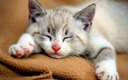

In [173]:
results = search_images_bing(key, 'cat')
ims = results.attrgot('contentUrl')
print(len(ims)) # check number of image results
dest = 'cat.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

Define fast foods of our interest and the path to keep the image files

In [175]:
fast_foods = 'hotdog', 'burger', 'pizza'
path = Path('fast_foods')

Download the images

In [176]:
if not path.exists():
  path.mkdir()
  for food in fast_foods:
    dest = (path/food)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{food}')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [177]:
fns = get_image_files(path)
fns

(#416) [Path('fast_foods/pizza/00000071.jpg'),Path('fast_foods/pizza/00000148.jpg'),Path('fast_foods/pizza/00000080.jpg'),Path('fast_foods/pizza/00000097.jpg'),Path('fast_foods/pizza/00000136.jpg'),Path('fast_foods/pizza/00000037.jpg'),Path('fast_foods/pizza/00000067.jpg'),Path('fast_foods/pizza/00000055.jpg'),Path('fast_foods/pizza/00000015.jpg'),Path('fast_foods/pizza/00000012.jpg')...]

Check and delete corrupted files

In [178]:
failed = verify_images(fns)
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

We need to create a `DataLoaders` object to provide data for the model. But to create it we need to specify
* What kinds of data we are working with
* How to get the list of items
* How to label these items
* How to create the validation set

We need to convert our downloaded images to a `DataBlock` object to create a `DataLoaders`. Here's the way we can do it:

In [179]:
fast_foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

The command has given us a template, but we still need to specify the actual source of the data:

In [180]:
dls = fast_foods.dataloaders(path)

Let's see a batch from the validation set:

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


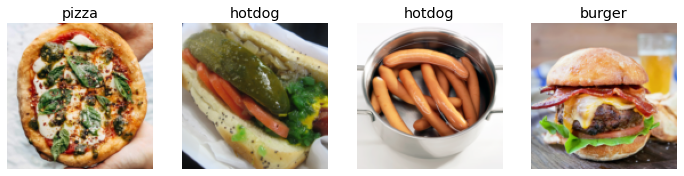

In [181]:
dls.valid.show_batch(max_n=4, nrows=1)

By default, `Resize` crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. `RandomResizedCrop` crops to randomly selected parts of an image. *Data augmentation* applies random variations in our data.

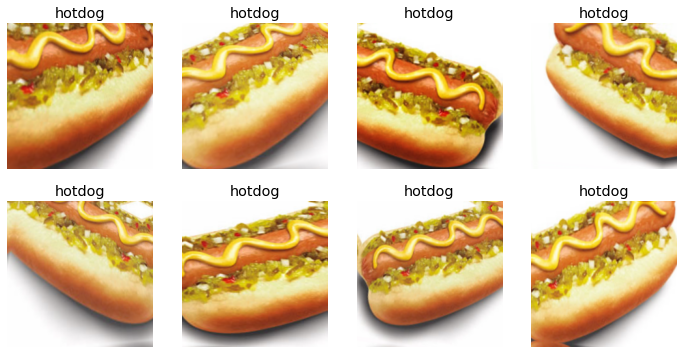

In [182]:
fast_foods = fast_foods.new(item_tfms=RandomResizedCrop(224, min_scale=0.4),
                batch_tfms=aug_transforms())
dls = fast_foods.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Fine-tuning the model

Now we create a `Learner` and fine-tune it.

In [187]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.548499,0.662376,0.209877,00:18


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.395079,0.283008,0.098765,00:19
1,0.271584,0.229012,0.098765,00:18
2,0.203993,0.297131,0.086420,00:19
3,0.157787,0.364181,0.111111,00:18
4,0.131485,0.405281,0.098765,00:19
5,0.118768,0.424894,0.098765,00:19
6,0.102281,0.428911,0.111111,00:18


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

Let's check the mistakes the model is making.

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


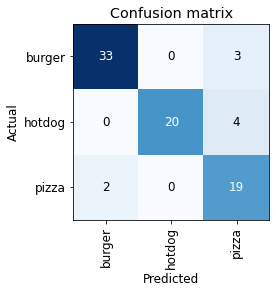

In [188]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Plot top losses

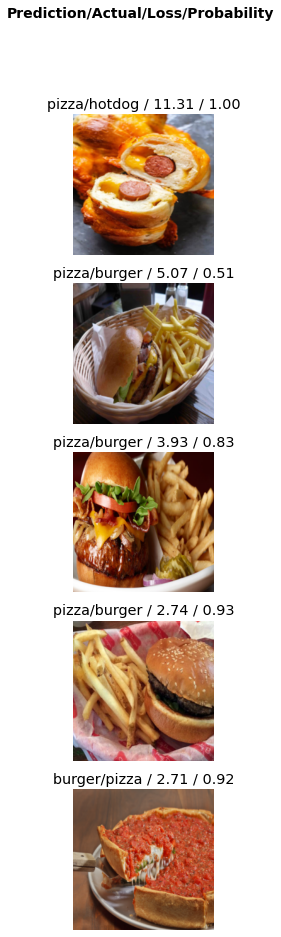

In [189]:
interp.plot_top_losses(5, nrows=5)

## Test the model

Let's test some of our own image.

In [ ]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(uploader.data[0])
food,_,probs = learn.predict(img)
print(f"Probability it's a {food}: {probs[0].item():.3f}")

Probability it's a burger: 1.000
